In [12]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
class Vocabulary(object):

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):

        if token_to_idx is None:
            token_to_idx = {}

        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx:token for token, idx in self._token_to_idx.items()}

        self._add_unk = add_unk
        self._unk_token = unk_token

        self.unk_index = -1

        if add_unk:
            self.unk_index = self.add_token(unk_token)

    def to_serializable(self):
        return {'token_to_idx': self._token_to_idx,
                'add_unk': self._add_unk,
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        cls(**contents)

    def add_token(self, token):

        try:
            index = self._token_to_idx[token]
        except:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def add_many(self, tokens):

        return {self.add_token(token) for token in tokens}

    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)







In [3]:
class SurnameVectorizer(object):

    def __init__(self, surname_vocab, nationality_vocab):

        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname:str):
        vocab = self.surname_vocab
        one_hot = np.zeros(len(vocab), dtype=np.float32)

        for token in surname:
           one_hot[vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, surname_df):
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)

        for index, row in surname_df.iterrows():
            for letter in row.surname:
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)

        return cls(surname_vocab, nationality_vocab)

    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab = Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab, nationality_vocab)


    def to_serializable(self):
        return {'surname_vocab': self.surname_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable()}



In [4]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):

        self.surname_df = surname_df
        self._vectorizer = vectorizer

        self.train_df = self.surname_df[self.surname_df.split == 'train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split == 'val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split == 'test']

        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        class_counts = surname_df.nationality.value_counts().to_dict() #每个国家的count

        def sort_key(item): #sorted by vocabulary index
            return self._vectorizer.nationality_vocab.lookup_token(item[0]) #return index

        self.sorted_class = sorted(class_counts.items(), key=sort_key) #sort 每个国家的count 根据vocabulary 的index
        frequencies = [count for _, count in self.sorted_class]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32) #每个国家的占比

    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split == 'train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))
    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):

        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):

        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(),fp)

    def get_vectorizer(self):
        return self._vectorizer

    def set_split(self, split='train'):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):

        row = self._target_df.iloc[index]

        surname_vector = self._vectorizer.vectorize(row.surname)
        nationality_index = self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_surname':surname_vector, 'y_nationality': nationality_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True, drop_last=True, device="cpu"):

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict



The Model

In [5]:
class SurnameClassifier(nn.Module):

    def __init__(self, input_dim, hidden_dim, out_dim):
        super(SurnameClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x_in, apply_softmax=False):
        intermediate_vector = self.fc1(x_in)
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector



### Training Loop

#### Helper function

In [6]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step':0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    elif train_state['epoch_index'] >= 1:
        """
        loss变差early stoping stop 增加
        loss减少， 如果低于early stopping best val 保存模型 重置early stopping step
        loss变差一定次数就停止
        """

        loss_tm1, loss_t = train_state['val_loss'][-2:] #最后两个

        if loss_t >= train_state['early_stopping_best_val']: #if loss  worsened
            #update step
            train_state['early_stopping_step'] += 1
        else: #loss decrease
            if loss_t <= train_state['early_stopping_best_val']: #save the best model
                torch.save(model.state_dict(), train_state['model_filename'])

            train_state['early_stopping_step'] = 0 #reset early stopping step

        #stop early? 如果变差一定次数就停止
        train_state['stop_early'] = train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):

    _, y_pred_indices = y_pred.max(dim=1) #第一个是value 第二个是index
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100






##### general utility

In [7]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)


In [8]:
args =Namespace(
    surname_csv="surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="/home/hc/TORCH_TUTOR/surname",
    hidden_dim=300,
    seed=1337,
    num_epochs=200,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=64,
    cuda=False,
    reload_from_file=False,
    expand_filepaths_to_save_dir=True,
)
if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)

    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))

#check cuda
if torch.cuda.is_available():
    args.cuda = True


args.device = torch.device("cuda" if args.cuda else "cpu" )
handle_dirs(args.save_dir)

set_seed_everywhere(args.seed, args.cuda)

Expanded filepaths: 
	/home/hc/TORCH_TUTOR/surname/vectorizer.json
	/home/hc/TORCH_TUTOR/surname/model.pth


### Initializations

In [9]:
if args.reload_from_file:
    print("Reloading")
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv, args.vectorizer_file)
else:
    print("Creating fresh")
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(input_dim=len(vectorizer.surname_vocab), hidden_dim=args.hidden_dim, out_dim=len(vectorizer.nationality_vocab))
print("epoch_num={},\tbatch_size={}, train_data_size={}".format(args.num_epochs, args.batch_size, len(dataset)))


Creating fresh
epoch_num=200,	batch_size=64, train_data_size=7680


### Training Loop


In [10]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)


print(dataset.class_weights)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs,position=0)

dataset.set_split('train')


train_bar = tqdm(desc="split=train", total=dataset.get_num_batches(args.batch_size), position=1,leave=True)


dataset.set_split('val')

val_bar = tqdm(desc="split=val", total=dataset.get_num_batches(args.batch_size),position=1, leave=True)



for epoch_index in range(args.num_epochs):
    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')

    batch_generator = generate_batches(dataset=dataset,
                                       batch_size=args.batch_size, device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):

        optimizer.zero_grad()

        y_pred = classifier(batch_dict['x_surname'])

        loss = loss_func(y_pred, batch_dict['y_nationality'])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)
        loss.backward()
        optimizer.step()

        acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)
        train_bar.set_postfix(loss=loss_t, acc=acc_t, epoch=epoch_index)
        train_bar.update()

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    batch_generator = generate_batches(dataset=dataset,
                                       batch_size=args.batch_size, device=args.device)
    dataset.set_split('val')
    running_loss = 0.
    running_acc = 0.
    classifier.eval()
    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred =  classifier(batch_dict['x_surname'])

        loss = loss_func(y_pred, batch_dict['y_nationality'])
        loss_t = loss.to("cpu").item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

        val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)

        val_bar.update()
    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    train_state = update_train_state(args=args, model=classifier,train_state=train_state)

    scheduler.step(train_state['val_loss'][-1])

    if train_state['stop_early']:
        break

    train_bar.n = 0
    val_bar.n = 0
    epoch_bar.set_postfix(early_stop=train_state['early_stopping_step'])
    epoch_bar.update()

tensor([0.0006, 0.0045, 0.0024, 0.0042, 0.0003, 0.0044, 0.0017, 0.0064, 0.0055,
        0.0017, 0.0013, 0.0130, 0.0083, 0.0182, 0.0004, 0.0133, 0.0039, 0.0172],
       device='cuda:0')


training routine:   0%|          | 0/200 [00:00<?, ?it/s]

split=train:   0%|          | 0/120 [00:00<?, ?it/s]

split=val:   0%|          | 0/25 [00:00<?, ?it/s]

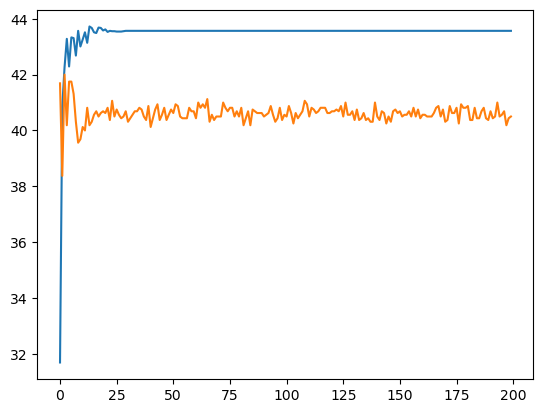

In [14]:
plt.plot(range(200),train_state['train_acc'])
plt.plot(range(200),train_state['val_acc'])

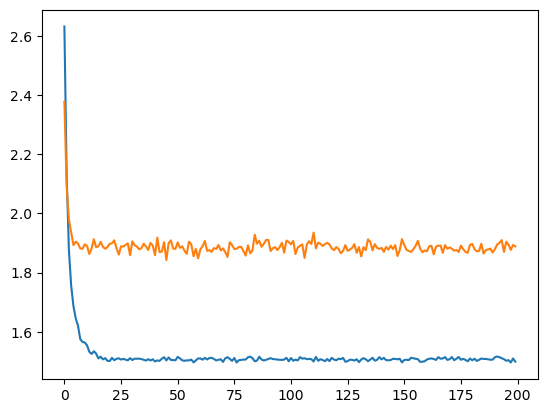

In [13]:
plt.plot(range(200),train_state['train_loss'])
plt.plot(range(200),train_state['val_loss'])